In [1]:
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import os
import sys
import torch
from torchmetrics.functional import *
import torch.nn as nn
import time
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import math
import random

In [2]:
pd.set_option('display.max_rows',500)

In [3]:
module_path = "..."
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from script import data_utils, helper_utils

In [5]:
data_path = module_path + '/data/ml-100k/'
delimiter ='\t'
col_names=['user_id', 'item_id', 'rating', 'timestamp']
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'  

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
data, num_users, num_items, sparsity = data_utils.read_data_ml100k(data_path, delimiter, col_names, url)

train_data, test_data = data_utils.split_data(data, num_users, num_items, split_mode='seq-aware', test_ratio=0.1)

users_train, items_train, ratings_train, candidates = data_utils.load_data(train_data, num_users, num_items, feedback='implicit')

users_test, items_test, ratings_test, test_iter_val = data_utils.load_data(test_data, num_users, num_items, feedback='implicit')

number of users: 943, number of items: 1682
matrix sparsity: 0.936953


In [10]:
class PRDataset(Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [11]:
# Create Dataset
train_set = PRDataset(users_train, items_train, candidates, num_items)
test_set = PRDataset(users_test, items_test, test_iter_val, num_items)

In [12]:
# Create Dataloader
batch_size = 1024
train_iter = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_iter = DataLoader(test_set, batch_size=batch_size)

In [13]:
iter(train_iter).next()

[tensor([536,   9,  27,  ..., 134, 724,  55]),
 tensor([962, 474, 229,  ...,  54, 878,   0]),
 tensor([1572,  536, 1292,  ...,  429, 1413,  856])]

In [14]:
# Create Dataloader
class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__( **kwargs)

    def forward(self, positive, negative):
        distances = (positive - negative)
        loss = -torch.sum(torch.log(torch.sigmoid(distances)), 0, keepdims=True)
        return loss

In [15]:
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super(MF, self).__init__()
        self.user_factors = nn.Embedding(num_users, num_factors)
        self.item_factors = nn.Embedding(num_items, num_factors)
        
        nn.init.normal_(self.user_factors.weight, std=0.01)
        nn.init.normal_(self.item_factors.weight, std=0.01)
        
    def forward(self, user, item):
        return ((self.user_factors(user) * self.item_factors(item)).sum(axis=1))
    
    def predict(self, user, item):
        return self.forward(user, item)

lr, num_epochs, wd, optimizer = 0.01, 8, 1e-5, 'adam'
model = MF(10, num_users, num_items).to(device)
loss = BPRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) 

In [16]:
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    model.train()
    train_l=0
    for i, values in enumerate(train_iter):
        input_data = []
        for v in values:
            input_data.append(v.to(device)) #you should load here to GPU's if you have more than 1 GPU
            
        p_pos = [model(torch.tensor([t[0]]).cuda(), torch.tensor([t[1]]).cuda()) for t in zip(*input_data[0:-1])]
        p_neg = [model(torch.tensor([t[0]]).cuda(), torch.tensor([t[1]]).cuda()) for t in zip(*input_data[0:-2], input_data[-1])] 
        ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
        optimizer.zero_grad()
        [l.backward(retain_graph=False) for l in ls]
        train_l += sum([l for l in ls])  #you should normalize by the number of devices if you have more than 1 GPU
        optimizer.step()
    train_loss_list.append(train_l)
    model.eval()
    test_l = 0
    with torch.no_grad():
        for i, values in enumerate(test_iter):
            input_data = []
            for v in values:
                input_data.append(v.to(device)) #you should load here to GPU's if you have more than 1 GPU

            p_pos = [model(torch.tensor([t[0]]).cuda(), torch.tensor([t[1]]).cuda()) for t in zip(*input_data[0:-1])]
            p_neg = [model(torch.tensor([t[0]]).cuda(), torch.tensor([t[1]]).cuda()) for t in zip(*input_data[0:-2], input_data[-1])] 
            ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            test_l += sum([l for l in ls])  #you should normalize by the number of devices if you have more than 1 GPU
        test_loss_list.append(test_l)

    print(epoch, train_l, test_l)


0 tensor([53241.5430], device='cuda:0', grad_fn=<AddBackward0>) tensor([474.2846], device='cuda:0')
1 tensor([29051.7656], device='cuda:0', grad_fn=<AddBackward0>) tensor([397.5166], device='cuda:0')
2 tensor([23844.8867], device='cuda:0', grad_fn=<AddBackward0>) tensor([391.2307], device='cuda:0')
3 tensor([21532.6914], device='cuda:0', grad_fn=<AddBackward0>) tensor([346.8315], device='cuda:0')
4 tensor([20240.6074], device='cuda:0', grad_fn=<AddBackward0>) tensor([363.7806], device='cuda:0')
5 tensor([19273.3145], device='cuda:0', grad_fn=<AddBackward0>) tensor([379.0472], device='cuda:0')
6 tensor([18215.1836], device='cuda:0', grad_fn=<AddBackward0>) tensor([375.9496], device='cuda:0')
7 tensor([17623.7500], device='cuda:0', grad_fn=<AddBackward0>) tensor([409.3091], device='cuda:0')


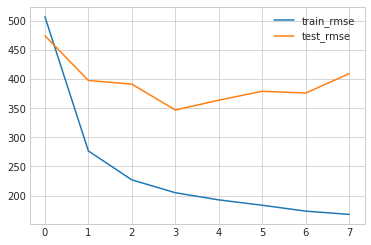

In [17]:
# Here we normalized the training error by the number of samples in each training and test bucket
gain=len(test_set)/len(train_set)
helper_utils.plot_error([x.cpu().detach().numpy()*gain for x in train_loss_list], 
                        [x.cpu().detach().numpy() for x in test_loss_list], num_epochs=num_epochs)

## Evaluate Model output using AUC and hit@50
hit@50 = 27% and AUC = 83%

In [24]:
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k]) if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist) if val in set(test_matrix)]
    maxx = len(rankedlist) - 1
    auc = 1.0 * (maxx - hits_all[0][0]) / maxx if len(hits_all) > 0 else 0
    return len(hits_k), auc


def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items, devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)]) #it was originally #users, shouldnt it be num_items?
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        x=[torch.Tensor(data).long() for data in x]
        test_data_iter = DataLoader(TensorDataset(*x), shuffle=False, batch_size=1024)
        for uu, ii in (test_data_iter):
            scores.extend((net(uu.to(device), ii.to(device))))
        #scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [25]:
hit_rate, auc = evaluate_ranking(model, test_iter_val, None, candidates, num_users, num_items,device)

In [26]:
print(hit_rate, auc)

0.32873806998939553 0.8711254558813524


In [27]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        print([name, param])
        total_params+=param
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

['user_factors.weight', 9430]
['item_factors.weight', 16820]
Total Trainable Params: 26250


26250